# Sattelite Images

[Kaggle Source](https://www.kaggle.com/rhammell/planesnet) <br>
[Other Clustering Project](https://medium.com/@h4k1m0u/clustering-a-satellite-image-with-scikit-learn-14adb2ca3790) <br>
[Image Source](https://developers.planet.com/planetschool/)

In [1]:
#----------data preprocessing-------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#------Neural Networks-----------
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

C:\Users\Darshil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data Preprocessing
- 1) reading in dataset
- 2) Viewing an image
- 3) Converting our "data" column (with lists of size 1x1200, 400 RGB each) into a dataframe of size 32000x1200
- 4) UNIFORMLY create new data out of dataframe and convert dataframe to numpy array of size num_datax20x20x3 
- 5) Split into training and testing and we need to one-hot code our test data

In [2]:
"""
1. Reading in Json file
"""
data_df = pd.read_json('C:/Users/Darshil/gitly/Deep-Learning/My Projects/sattelite_CNN/planesnet.json')

#lets take a look at our data
data_df.head()

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64


The length of the image vector 1200 
 ----------------------------------


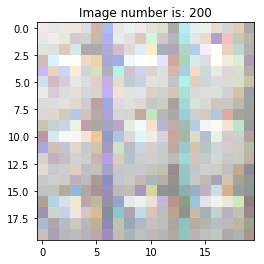

In [3]:
""" 
Lets take a look at dataframe data_df
-----------------------------

- Data  : a list of 1200 pixel values of each image
- labels : 0 or 1 for plane or no-plane in the image
Everything else for now is redundant


2. Viewing an image
"""

#data column first image
print ('The length of the image vector', len(data_df['data'].iloc[1,]), '\n', 
       '----------------------------------')

#Lets take a look at the image!

image_num = 200
a = np.array(data_df.iloc[image_num,0]).reshape(20,20,3)
plt.imshow(a)
plt.title('Image number is: {}'.format(image_num))
plt.show()

In [4]:
"""
3. Pandas series to dataframe and then we need to randomly shuffle 
(https://stackoverflow.com/questions/45901018/convert-pandas-series-of-lists-to-dataframe)

We're also going to add the label column to our pixel_df
"""
#Now we're going to transpose s
pixel_df = pd.DataFrame.from_items(zip(data_df['data'].index, data_df['data'].values)).T

#adding the label column
pixel_df['labels'] = data_df['labels']
pixel_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,labels
0,206,195,187,183,177,175,174,193,198,197,...,191,193,197,196,198,231,224,194,164,1
1,215,209,200,196,192,197,205,168,155,160,...,190,185,182,192,201,204,205,207,210,1
2,204,214,220,219,213,205,198,193,199,186,...,171,174,173,174,176,171,167,163,157,1
3,179,174,179,178,173,170,168,168,168,170,...,150,152,164,171,171,171,170,169,163,1
4,222,222,218,214,208,205,207,206,206,207,...,164,164,161,156,163,164,166,158,147,1


In [5]:
"""
Convert Pandas dataframe of size 32000x1200 to numpy array of size 32Kx1200
NOTE! We need to reshape out data to size number_of_datapoints x 20x20x3 where 20x20x3 are the dimensions 
..for each colored image

Furthermore, its important to understand that because the labels in our dataset are not uniform, ie: there are 24K images 
...with no planes and only 8K images with planes in them, it is important to uniformly distribute the data to train on
"""


#------------creating a uniform dataset-------------

#random seed
random.seed(2)
#We create a new dataframe that we will append to 
new_df = pd.DataFrame(index=[0], columns=pixel_df.columns)
new_df = new_df.fillna(0)

#determine size of dataset (can go max 8K for label==1)
size_dataset = 16000

for x in list(set(pixel_df['labels'])):
    
    #first we subset the datatframe
    a = pixel_df[pixel_df['labels']==x]
    
    #randomly choose N/2 indices
    rands = random.sample(list(a.index),int(size_dataset/2))
    
    #pick the indices
    b = a.loc[rands] 
    
    #append to existing dataframe 
    new_df = pd.concat([new_df,b])
    
    #dropping first row which was just initialized to 0
    new_df = new_df.iloc[1:,:].dropna(axis=0)
    
#RANDOMLY SHUFFLE AGAIN
rands1 = random.sample(list(new_df.index),size_dataset-1)
new_df = new_df.loc[rands1]
        
print ('Confirming that our dataset is uniformly distributed', '\n', 
       '--------------------------')
print (new_df['labels'].value_counts(dropna=False))

shuffled_pixel_df= new_df

Confirming that our dataset is uniformly distributed 
 --------------------------
1    8000
0    7999
Name: labels, dtype: int64


In [6]:
#---determine training and test data sizes-----
training_size = int(0.95 * size_dataset)

#-----training data-----
training_data = np.array(shuffled_pixel_df.iloc[0:training_size,:1200])
training_data_labels = np.array(pd.get_dummies(shuffled_pixel_df.iloc[0:training_size,1200]))  #one-hot coding and then converting to numpy
print ('Size of training data: ',training_data.shape[0], '\n',
      'Size of training data labels: ',training_data_labels.shape[0] , '\n \n')

#-----test data-----
test_data = np.array(shuffled_pixel_df.iloc[training_size:,:1200])
test_data_labels = np.array(pd.get_dummies(shuffled_pixel_df.iloc[training_size:,1200]))
print ('Size of test data: ',test_data.shape[0], '\n',
      'Size of test data labels: ',test_data_labels.shape[0] )


print ('Confirming that the training and test data sizes equal to total size of dataset: ', training_data.shape[0] + test_data.shape[0])



#reshaping our training and test data HERE!
training_pixel_np = training_data.reshape(training_size,20,20,3)
test_pixel_np = test_data.reshape(test_data.shape[0],20,20,3)

Size of training data:  15200 
 Size of training data labels:  15200 
 

Size of test data:  799 
 Size of test data labels:  799
Confirming that the training and test data sizes equal to total size of dataset:  15999


In [7]:
print ('Training data shape after reshaping: ', training_pixel_np.shape,'\n',
'Test data shape after reshaping: ', test_pixel_np.shape)

Training data shape after reshaping:  (15200, 20, 20, 3) 
 Test data shape after reshaping:  (799, 20, 20, 3)


# Neural Network:  Model Without Data Augmentation

In [8]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape = (20,20,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))

In [9]:

#print out model summary
model.summary()

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               331904    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

In [32]:
history = model.fit(training_pixel_np,training_data_labels,
                   batch_size = 200,
                   epochs=10,
                   verbose=1,
                   validation_data = (test_pixel_np, test_data_labels))

Train on 15200 samples, validate on 799 samples
Epoch 1/10
 5000/15200 [========>.....................] - ETA: 3s - loss: 4.6202 - acc: 0.6976

KeyboardInterrupt: 

In [39]:
#lets take random images and predict
preds = model.predict(training_pixel_np[1:10])
np.round(preds)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# Neural Network:  Model Using Data Augmentation

In [17]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape = (20,20,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))

#print out model summary
model.summary()

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               331904    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [18]:
image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,   #rotate images
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)   #flip horizontally

#training the image preprocessing
image_gen.fit(training_pixel_np, augment=True)

In [28]:
"""
HOW DATA AUGMENTATION WORKS?
Data augmentation works as follows: at each learning epoch transformations with randomly 
selected parameters within the specified range are applied to all original images in the training set. 
After an epoch is completed, i.e. after having exposed a learning algorithm to the entire set of training data, 
the next learning epoch is started and training data is once again augmented by applying specified transformations 
to the original training data.

Important parameters: 
batch_size = selected batch of training data fed to NN
steps_per_epoch = batch size forward and back propogated this many times for each epoch. 
   ...I think this number = number of augmented images for each image


"""

model.fit_generator(image_gen.flow(training_pixel_np, training_data_labels, batch_size=200),           
          steps_per_epoch = training_pixel_np.shape[0]/32,
          epochs=10,
          verbose=1,
          validation_data = (test_pixel_np, test_data_labels))

Epoch 1/10
475/475 [==============================] - 58s 121ms/step - loss: 0.4732 - acc: 0.7696 - val_loss: 6.9355 - val_acc: 0.5582
Epoch 2/10
475/475 [==============================] - 56s 118ms/step - loss: 0.4597 - acc: 0.7788 - val_loss: 7.3108 - val_acc: 0.5357
Epoch 3/10
475/475 [==============================] - 57s 120ms/step - loss: 0.4510 - acc: 0.7850 - val_loss: 6.8284 - val_acc: 0.5645
Epoch 4/10
475/475 [==============================] - 56s 118ms/step - loss: 0.4426 - acc: 0.7908 - val_loss: 7.0974 - val_acc: 0.5569
Epoch 5/10
475/475 [==============================] - 57s 119ms/step - loss: 0.4326 - acc: 0.7980 - val_loss: 6.3726 - val_acc: 0.5920
Epoch 6/10
251/475 [==============>...............] - ETA: 27s - loss: 0.4291 - acc: 0.7997

KeyboardInterrupt: 

In [40]:
#lets take random images and predict
a = model.predict(training_pixel_np[1:15])
np.round(a)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)